# A code example: The intraday seasonality of the spread

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def binning(x,y,nbin=10,eq = True):
    step = (np.max(x)-np.min(x))/(nbin)
    X = []
    Y = []
    Yerr = []
    tmpY = []
    start = np.min(x)+step
    if eq:
        for i in range(len(x)):
            while x[i] > start:
                X.append(start-step/2)
                Y.append(np.mean(tmpY))
                #Xerr.append(np.std(tmpX,ddof=1) /np.sqrt(len(tmpX)) )
                Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
                start += step
                tmpY=[]
                pass
            tmpY.append(y[i])
            pass
        if len(tmpY)!=0:
            X.append(start-step/2)
            Y.append(np.mean(tmpY))
            Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
        return X,Y,Yerr
        pass
    else:
        tmpX = []
        Xerr = []
        for i in range(len(x)):
            while x[i] > start:
                X.append(np.mean(tmpX))
                Y.append(np.mean(tmpY))
                Xerr.append(np.std(tmpX,ddof=1) /np.sqrt(len(tmpX)) )
                Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
                start += step
                tmpX=[]
                tmpY=[]
                pass
            tmpX.append(x[i])
            tmpY.append(y[i])
            pass
        if len(tmpY)!=0:
            X.append(np.mean(tmpX))
            Y.append(np.mean(tmpY))
            Xerr.append(np.std(tmpX,ddof=1) /np.sqrt(len(tmpX)) )
            Yerr.append(np.std(tmpY,ddof=1) /np.sqrt(len(tmpY)) )
        return X, Y, Yerr

In [3]:
def PreProcessing(t,spread):
    T = np.zeros(len(t))
    Spread = np.zeros(len(t))
    prev = t[0]
    n = 0
    for i in range(len(t)):
        n += (prev != t[i])
        T[n] = t[i]
        Spread[n] = spread[i]
        prev = t[i]
        pass
    return T[:n+1],Spread[:n+1]

In [4]:
def TimeMean(t, y, prev, start, end):
    T = np.diff(t)
    Y = np.sum(y[1:]*T) + (end-t[-1])*y[-1] + (t[0]-start)*prev
    return Y/(end-start)

def IntradaySeasonality_Spread(t,spread, start=34200 , end= 57600 ,step = 60):
    t = np.array(t)
    spread = np.array(spread)
    T = np.arange(start,end+step,step)
    prev = spread[0]
    result_S = np.zeros(len(T)-1)
    for i in range(len(T)-1):
        use = ((T[i]<=t) & (t<T[i+1]))
        tmp_t = t[use]
        tmp_s = spread[use]
        result_S[i] = TimeMean(tmp_t, tmp_s, prev, T[i], T[i+1])
        prev = tmp_s[-1]
        pass
    
    return T[1:] -step/2, result_S

In [13]:
def TimeMean(t, y, prev, start, end):
    T = np.diff(t)
    Y = np.sum(y[1:]*T) + (end-t[-1])*y[-1] + (t[0]-start)*prev
    return Y/(end-start)

def IntradaySeasonality_Spread(t,spread, start=34200 , end= 57600 ,step = 60):
    t = np.array(t)
    spread = np.array(spread)
    T = np.arange(start,end+step,step)
    prev = spread[0]
    result_S = np.zeros(len(T)-1)
    for i in range(len(T)-1):
        use = ((T[i]<=t) & (t<T[i+1]))
        tmp_t = t[use]
        tmp_s = spread[use]
        if len(tmp_t)>0:
            result_S[i] = TimeMean(tmp_t, tmp_s, prev, T[i], T[i+1])
            prev = tmp_s[-1]
            pass
        else:
            result_S[i] = result_S[i-1]
            #prev = tmp_s[i-1]
        pass
    
    return T[1:] -step/2, result_S

In [6]:
INTC_LOB   = np.sort(["../../Data/INTC/"+i for i in os.listdir("../../Data/INTC") if i[-8]=="k"])
TSLA_LOB   = np.sort(["../../Data/TSLA/"+i for i in os.listdir("../../Data/TSLA") if i[-8]=="k"])
INTC_order = np.sort(["../../Data/INTC/"+i for i in os.listdir("../../Data/INTC") if i[-8]!="k"])
TSLA_order = np.sort(["../../Data/TSLA/"+i for i in os.listdir("../../Data/TSLA") if i[-8]!="k"])

In [14]:
TSLA_t,TSLA_y = [[] for i in range(len(TSLA_order))],[[] for i in range(len(TSLA_order))]
n = 0
for i,z in zip(TSLA_order,TSLA_LOB):
    data = pd.read_csv(i,header=None)[0]
    lob = pd.read_csv(z,header=None)[[0,2]]
    spread = lob[0]-lob[2]
    a,b = PreProcessing(data.values,spread.values)
    a,b = IntradaySeasonality_Spread(a,b, start=34200 , end= 57600 ,step = 1)
    TSLA_t[n] = a.copy()
    TSLA_y[n] = b.copy()
    n+=1
    pass


In [23]:
import statsmodels.tsa.api as ts

In [41]:
acf = [ts.acf(i,nlags=1000,) for i in TSLA_y]
acf = np.array(acf)
t = np.arange(1,1001)


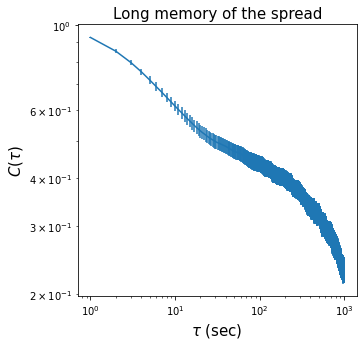

In [46]:
fig,ax = plt.subplots(figsize=(5,5))
ax.errorbar(t,[np.mean(acf[:,i+1]) for i in range(0,1000,1)], yerr = [np.std(acf[:,i+1],ddof=1)/np.sqrt(20) for i in range(0,1000,1)])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(r"$\tau$ (sec)",fontsize=15)
ax.set_ylabel(r"$C(\tau)$",fontsize=15)
ax.set_title("Long memory of the spread",fontsize=15)
plt.savefig("LongMemory_spread.png")
plt.savefig("../../../docs/CodeExample/StylizedFacts/LongMemory_spread.png")